# Imports

In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
import torch
from openretina.hoefling_2024.configs import model_config, trainer_config
from openretina.hoefling_2024.data_io import natmov_dataloaders_v2
from openretina.hoefling_2024.models import SFB3d_core_SxF3d_readout
from openretina.neuron_data_io import make_final_responses
from openretina.training import standard_early_stop_trainer as trainer
from openretina.utils.h5_handling import load_h5_into_dict
from openretina.utils.misc import CustomPrettyPrinter

from rgc_natstim_model.constants.identifiers import dh2eh
from rgc_natstim_model.constants.paths import base_directory

%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pp = CustomPrettyPrinter(indent=4, max_lines=15)

/gpfs01/euler/User/fdagostino/miniconda3/envs/py10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load data

In [2]:
dataset_hashes = list(dh2eh.keys())

file_name_template = r"2024-06-17_neuron_data_stim_c285329_responses_{}_wri.h5"
data_file_names = [file_name_template.format(dh[:7]) for dh in dataset_hashes]

# Select example dataset to train a model on
example_data_file_name = data_file_names[0]

movie_file_name = "2024-01-11_movies_dict_c285329.pkl"

if example_data_file_name == "5e620609fc7b491aa5edb4a5d4cd7276":
    # different stimuli for this dataset
    movie_file_name = "2024-05-27_movies_dict_41fc277.pkl"

In [3]:
movies_dict = pickle.load(open(os.path.join(base_directory, "data", "movie", movie_file_name), "rb"))
neural_responses = load_h5_into_dict(os.path.join(base_directory, "data", "base", example_data_file_name))
upsampled_neural_responses = make_final_responses(neural_responses, response_type="natural")

Loading HDF5 file contents: 100%|██████████| 385/385 [00:11<00:00, 34.38item/s]
Upsampling natural traces to get final responses.: 100%|██████████| 11/11 [00:00<00:00, 40.65it/s]


In [4]:
pp.pprint(movies_dict)

{   'eye': 'right',
    'random_sequences': numpy.ndarray(shape=(108, 20)),
    'test': numpy.ndarray(shape=(2, 750, 18, 16)),
    'train': numpy.ndarray(shape=(2, 16200, 18, 16))}


In [5]:
pp.pprint(upsampled_neural_responses)

{   'session_1_ventral1_20210929': {   'chirp_detrended_snippets': numpy.ndarray(shape=(86, 258, 5)),
                                       'chirp_detrended_snippets_times': numpy.ndarray(shape=(86, 258, 5)),
                                       'chirp_detrended_traces': numpy.ndarray(shape=(86, 1549)),
                                       'chirp_raw_traces': numpy.ndarray(shape=(86, 1549)),
                                       'chirp_smoothed_snippets': numpy.ndarray(shape=(86, 258, 5)),
                                       'chirp_smoothed_traces': numpy.ndarray(shape=(86, 1549)),
                                       'chirp_traces_times': numpy.ndarray(shape=(86, 1549)),
                                       'chirp_trigger_times': numpy.ndarray(shape=(86, 10)),
                                       'corr_to_avg': numpy.ndarray(shape=(86,)),
                                       'date': '2021-09-29',
                                       'exp_num': 1,
                   

# Prepare dataloaders

In [6]:
dataloaders = natmov_dataloaders_v2(upsampled_neural_responses, movies_dict, seed=1000)

Creating movie dataloaders: 100%|██████████| 11/11 [00:00<00:00, 14.82it/s]


In [7]:
pp.pprint(dataloaders)

{   'test': {   'session_1_ventral1_20210929': torch.utils.data.DataLoader(Dataset: MovieDataSet with 86 neuron responses to a movie of shape [2, 750, 18, 16].),
                'session_1_ventral1_20210930': torch.utils.data.DataLoader(Dataset: MovieDataSet with 69 neuron responses to a movie of shape [2, 750, 18, 16].),
                'session_1_ventral2_20210929': torch.utils.data.DataLoader(Dataset: MovieDataSet with 90 neuron responses to a movie of shape [2, 750, 18, 16].),
                'session_1_ventral2_20210930': torch.utils.data.DataLoader(Dataset: MovieDataSet with 103 neuron responses to a movie of shape [2, 750, 18, 16].),
                'session_2_ventral1_20210929': torch.utils.data.DataLoader(Dataset: MovieDataSet with 65 neuron responses to a movie of shape [2, 750, 18, 16].),
                'session_2_ventral2_20210929': torch.utils.data.DataLoader(Dataset: MovieDataSet with 95 neuron responses to a movie of shape [2, 750, 18, 16].),
                'session_2_

# Model init

In [8]:
model = SFB3d_core_SxF3d_readout(**model_config, dataloaders=dataloaders, seed=42)

{'session_1_ventral1_20210929': {'inputs': torch.Size([32, 2, 50, 18, 16]), 'targets': torch.Size([32, 50, 86])}, 'session_1_ventral1_20210930': {'inputs': torch.Size([32, 2, 50, 18, 16]), 'targets': torch.Size([32, 50, 69])}, 'session_1_ventral2_20210929': {'inputs': torch.Size([32, 2, 50, 18, 16]), 'targets': torch.Size([32, 50, 90])}, 'session_1_ventral2_20210930': {'inputs': torch.Size([32, 2, 50, 18, 16]), 'targets': torch.Size([32, 50, 103])}, 'session_2_ventral1_20210929': {'inputs': torch.Size([32, 2, 50, 18, 16]), 'targets': torch.Size([32, 50, 65])}, 'session_2_ventral2_20210929': {'inputs': torch.Size([32, 2, 50, 18, 16]), 'targets': torch.Size([32, 50, 95])}, 'session_2_ventral2_20210930': {'inputs': torch.Size([32, 2, 50, 18, 16]), 'targets': torch.Size([32, 50, 88])}, 'session_3_ventral2_20210929': {'inputs': torch.Size([32, 2, 50, 18, 16]), 'targets': torch.Size([32, 50, 115])}, 'session_3_ventral2_20210930': {'inputs': torch.Size([32, 2, 50, 18, 16]), 'targets': torch.S

/gpfs01/euler/User/fdagostino/miniconda3/envs/py10/lib/python3.10/site-packages/openretina/hoefling_2024/models.py:813: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3675.)
  return mask.T


# Training

In [9]:
test_score, val_score, output, model_state = trainer(
    model=model,
    dataloaders=dataloaders,
    seed=1000,
    **trainer_config,
)

Random seed 1000 has been set.


/gpfs01/euler/User/fdagostino/miniconda3/envs/py10/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
Epochs:  13%|█▎        | 63/500 [03:09<21:56,  3.01s/it]


In [10]:
print(f"Training finished with test correlation: {test_score:.4f}")

Training finished with test correlation: 0.4890


# Plotting an example test reconstruction

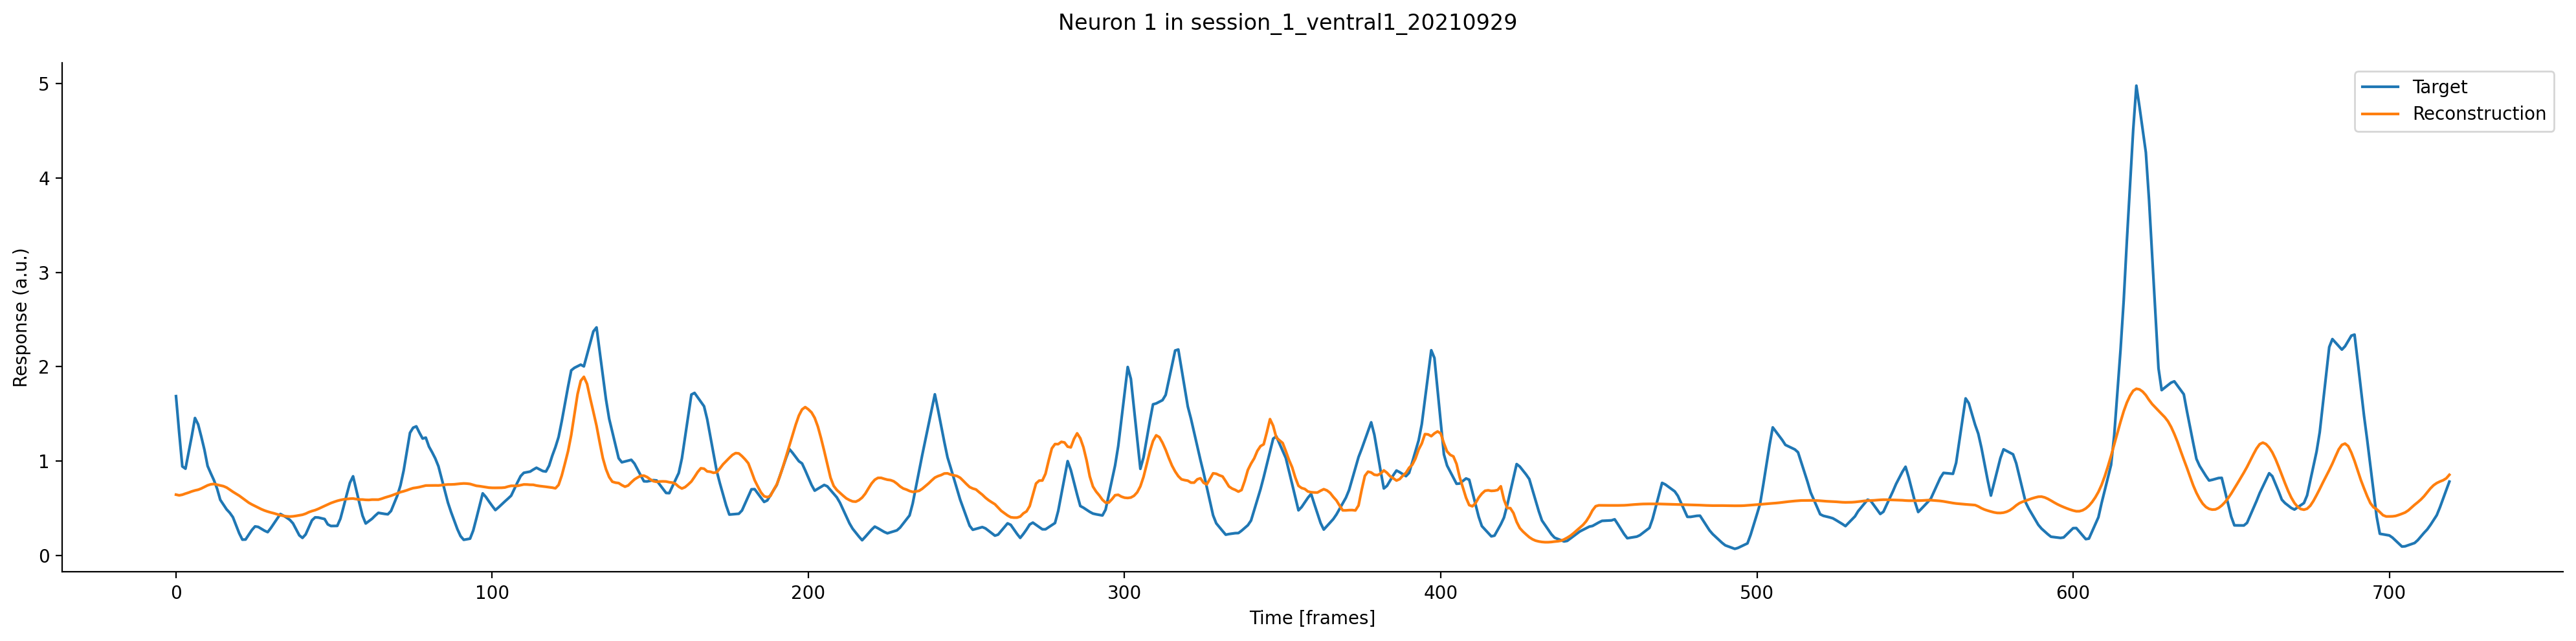

In [21]:
test_example_field = next(iter(dataloaders["test"].keys()))
test_batch = next(iter(dataloaders["test"][test_example_field]))
input_samples = test_batch.inputs
targets = test_batch.targets
input_samples.shape
with torch.no_grad():
    reconstructions = model(input_samples.to("cuda:0"), test_example_field)

reconstructions = reconstructions.cpu().numpy().squeeze()
targets = targets.cpu().numpy().squeeze()


example_neuron_idx = 1
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(targets[30:, example_neuron_idx], label="Target")
ax.plot(reconstructions[:, example_neuron_idx], label="Reconstruction")

ax.set_xlabel("Time [frames]")
ax.set_ylabel("Response (a.u.)")

fig.suptitle(f"Neuron {example_neuron_idx} in {test_example_field}")
ax.legend()
sns.despine()

plt.tight_layout()
plt.show()